<a href="https://colab.research.google.com/github/githublior/chess-piece-recognition/blob/main/chess_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Pieces Classifier Project
#Lior Shimon
 In this project i want to build a model that classify images into the 6 chess pieces (Rook, Bishop, Pawn , Queen, King) using a deep learning model.
I use Pytorch library, the dataset is downloaded from Kaggle.
I preprocessed the images by using edge detection and blur filter.



I.1 installing relevant libraries

In [ ]:
!pip3 install torch
!pip install PyDrive



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


I.2 connected to google drive and go to the relevant directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My\ Drive/chess_classifier
%pwd
%ls

/content/gdrive/My Drive/chess_classifier
Chessman-image-dataset/  dataloader.py  model.py  open_model.py  stam.py
classify_chess.pkl       main.py        Net.py    __pycache__/


In [ ]:
import dataloader
import Net
import sys
import pickle
import datetime
import torchvision
import torchvision.transforms as transforms

from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from torch.cuda import is_available
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import numpy as np
from PIL import Image
import os

In [ ]:


def train(epochs, model, data_train, data_dev, optimizer, criterion, batch):
    model.train()
    acc_val_list =[]
    loss_val_list = []
    acc_train_list = []
    loss_train_list = []
    tr_loss = 0
    for ep in range(epochs):
        i = 0
        correct = 0
        total = 0

        for x, y in data_train:
            i += 1

            # converting the data into GPU format
            if is_available():
                x = x.cuda()
                y = y.cuda()
                # x_val = x.cuda()
                # y_val = y_val.cuda()

            # clearing the Gradients of the model parameters
            optimizer.zero_grad()

            # > network = Network()
            #
            # > train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
            # > batch = next(iter(train_loader))  # Getting a batch
            # > images, labels = batch

            # prediction for training and validation set
            output_train = model(x)
            # output_val = model(x_val)

            # computing the training and validation loss
            loss_train = criterion(output_train, y)

            total += y.size(0)
            _, predicted = torch.max(output_train.data, 1)
            correct += (predicted == y).sum().item()
            #
            # print('output of the model : \t', torch.argmax(torch.FloatTensor(output_train[0])), "\n")
            # print('expected output:\t', torch.LongTensor(y),"\n")

            # print("\t \t \t training for epoch [{}/{}], batch[{}/{}]".format(ep+1, epochs, i, int(400/batch) ))

            # # loss_val = criterion(output_val, y_val)
            # train_losses.append(loss_train)
            # val_losses.append(loss_val)

            # computing the updated weights of all the model parameters
            loss_train.backward()
            optimizer.step()
            tr_loss = loss_train.item()

        #AT THE END OF A FULL EPOCH : check model with val
        # print("\t Checking result for epoch [{}/{}], batch[{}/{}]".format(ep+1, epochs, i, int(400 / BATCHSIZE)))

        acc_train = correct / total
        acc_train_list.append(acc_train)
        loss_train_list.append(tr_loss)
        # if (ep + 1) % 1 == 0:
        print(
            'Epoch [{}/{}], train_Loss: {:.4f}, train_Accuracy: {:.2f}%'.format(ep + 1, epochs,
                                                                                tr_loss,
                                                                                acc_train * 100))
        acc_val , loss_val = check_accuracy_with_dev(data_dev, model, ep, epochs)
        acc_val_list.append(acc_val)
        loss_val_list.append(loss_val)
        # acc_tr , loss_tr = check_accuracy_with_train(data_train, model, ep, epochs, batch)




    return model , acc_train_list , loss_train_list, acc_val_list, loss_val_list


In [ ]:

def check_accuracy_with_dev(data_dev, model , ep, epochs):
    model.eval()
    with torch.no_grad():
        correct = 0
        total=0
        for xv, yv in data_dev:
            if is_available():
                xv = xv.cuda()
                yv = yv.cuda()
            output_v = model(xv)
            loss_v = criterion(output_v, yv)

            total += yv.size(0)
            _, predicted = torch.max(output_v.data, 1)
            #print("pred", predicted)
            #print("yv", yv)
            correct += (predicted == yv).sum().item()
            #if predicted == yv: correct+=1
        acc_val =correct / total
        # if (ep + 1) % 1 == 0:
        print(
            'Epoch [{}/{}], dev_Loss: {:.4f}, dev_Accuracy: {:.2f}%'.format(ep + 1, epochs,
                                                                            loss_v.item(),
                                                                            (correct / total) * 100))
    model.train()
    return acc_val, loss_v.item()


In [ ]:

def check_accuracy_with_train(data_train, model , ep, epochs, batch_size):
    model.eval()
    with torch.no_grad():
        correct = 0
        total=0
        for xt, yt in data_train:
            if is_available():
                xt = xt.cuda()
                yt = yt.cuda()
            output_t = model(xt)
            loss_t = criterion(output_t, yt)

            total += batch_size
            _, predicted = torch.max(output_t.data, 1)
            correct += (predicted == yt).sum().item()
        acc_train =correct / total
        # if (ep + 1) % 1 == 0:
        print('Epoch [{}/{}], train_Loss: {:.4f}, train_Accuracy: {:.2f}%'.format(ep + 1, epochs, loss_t.item(),acc_train * 100))
    model.train()
    return acc_train, loss_t.item()


In [ ]:
def use_model(model, data):
    for x,y in data:
        output=model(x)
        print('output of the model : \t', torch.argmax(torch.FloatTensor(output[0])), "\n")



In [ ]:
def plot_loss_acc(loss_train_list, loss_val_list, acc_or_loss):
  # Plotting both the curves simultaneously
  plt.plot([i for i in range(len(loss_train_list))], loss_train_list, color='g', label= acc_or_loss + ' train')
  plt.plot([i for i in range(len(loss_train_list))], loss_val_list, color='r', label= acc_or_loss +'loss dev')

  # Naming the x-axis, y-axis and the whole graph
  plt.xlabel("epoch")
  plt.ylabel(acc_or_loss + "%")
  plt.title("train & dev" + acc_or_loss + "evolution over epochs")

  plt.legend()
  plt.show()


Hyper-Parameters

In [ ]:
path1 = "./Chessman-image-dataset/Chess"
path_to_aug = "./Chessman-image-dataset/Augmented_Chess"
path_to_aug_2 = "./Chessman-image-dataset/Aug_Chess_2"
path2=  "./Chessman-image-dataset/prepro_chess"
LR = 0.001
BATCHSIZE = 100
EPOCHS = 170
MMTM = .001
random_seed= 10
WD = 0.05


formating and augmenting Dataset

In [ ]:
#%pwd
#%cd ./Chessman-image-dataset/Chess/Bishop/
#%pwd
#%ls | wc -l
#%cd /content/gdrive/My Drive/chess_classifier/Chessman-image-dataset/Augmented_Chess/Bishop/
#%pwd
#%ls | wc -l
#%cd /content/gdrive/My Drive/chess_classifier/Chessman-image-dataset/Aug_Chess_2/Bishop/
#%pwd
#%ls | wc -l
#%cd /content/gdrive/My Drive/chess_classifier

In [ ]:
# Define the transforms for data augmentation and normalization
transform_dataset = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomVerticalFlip(p=.5),
    transforms.RandomRotation(50),
    transforms.RandomGrayscale(p=.2),
    transforms.ColorJitter(brightness=.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

format_dataset = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the data from the folders
dataset = torchvision.datasets.ImageFolder(root=path1, transform=format_dataset)

generator1 = torch.Generator().manual_seed(random_seed)
trainset1 , validationset1 , testset1 =  torch.utils.data.random_split(dataset, [.88 , .11 , .01], generator1)
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
validloader1 = torch.utils.data.DataLoader(validationset1,  shuffle=True, num_workers=2)
testloader1 = torch.utils.data.DataLoader(testset1, shuffle=True, num_workers=2)


Augmenting the data and store them in "Augmented_Chess" folder in Drive

In [ ]:

def Create_augm_data():
  tensor_to_pil = torchvision.transforms.ToPILImage()
  pil_to_tensor = torchvision.transforms.PILToTensor()
  augm_num = 0
  for i in range(len(dataset)):
    img = dataset[i][0]
    lbl = dataset[i][1]
    img_path = dataset.imgs[i][0]
    # print(img_path)
    path_split = img_path.split('/') #[len(image_path.split('/'))-2:][0]
    classname = path_split[-2]
    source_filename = path_split[-1]
    for _ in range(10):
      aug_filename  = "augm_" + str(augm_num + 1) + path_split[-1]
      aug = transform_dataset(tensor_to_pil(img))
      augmented_image_path = os.path.join(path_to_aug_2,classname, aug_filename)
      torchvision.utils.save_image(aug, augmented_image_path)
      augm_num += 1



    #aug_t = aug.numpy().transpose((1, 2, 0))
    #plt.imshow(aug_t)
    #plt.show()

    source_image_path = os.path.join(path_to_aug_2,classname, source_filename)
    torchvision.utils.save_image(img, source_image_path)
    #img_t = img.numpy().transpose((1, 2, 0))
    #plt.imshow(img_t)
    #plt.show()




preparing Train , validation and test datasets

In [ ]:
augmented_ds = torchvision.datasets.ImageFolder(root=path_to_aug_2, transform=format_dataset)


generator1 = torch.Generator().manual_seed(random_seed)
trainset , validationset , testset =  torch.utils.data.random_split(augmented_ds, [.8 , .19 , .01], generator1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validationset,  shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


vizualise images from datasets

In [ ]:
def check_vizualise_data_from_dataloaders():

  index = np.random.randint(len(trainset1))
  index =2

  image_t, label_t = trainset1[index]
  #print(image_t)
  print(type(image_t))
  pil_to_tensor = torchvision.transforms.PILToTensor()

  image_t = image_t.numpy().transpose(1, 2, 0) # Convert the tensor to a numpy array and transpose the dimensions

  # Display the image
  plt.imshow(image_t)
  plt.title('Label tr: %d' % label_t)

  plt.show()

  image_ts, label_ts = testset[index]
  #print(image_ts)
  print(type(image_ts))
  image_ts = image_ts.numpy().transpose(1, 2, 0) # Convert the tensor to a numpy array and transpose the dimensions

  # Display the image
  plt.imshow(image_ts)
  plt.title('Label ts: %d' % label_ts)

  plt.show()


In [ ]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.4)
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.BN1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 8, 3) # 16*61*61
        self.BN2 = nn.BatchNorm2d(num_features=8)

        self.conv3 = nn.Conv2d(10, 5, 5) # 16*61*61
        self.fc1 = nn.Linear(8 *62 *62 , 10)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(10, 6) # 6 output classes

    def forward(self, x):
        #x = self.dropout(x)
        #print("avant", len(x), len(x[0]), len(x[0][1]), len(x[0][2]))

        x = self.pool(nn.functional.relu(self.BN1(self.conv1(x))))
        #print("apres 1er conv inclu relu", len(x), len(x[0]), len(x[0][1]), len(x[0][2]))
        x = self.dropout(x)

        x = self.pool(nn.functional.relu(self.BN2(self.conv2(x))))
        x = self.dropout(x)
        #x = x.view(-1, 16 * 250*250)
        #print("apres 2eme conv, inclu pool + dropout ", len(x), len(x[0]), len(x[0][1]), len(x[0][2]))
        #print('len conv2',len(x[0]), len(x[0][0]), len(x[0][0][0])) 16x61x61

        #x = self.pool(nn.functional.relu(self.conv3(x)))
        #print("apres dernier drop out et conv3", len(x), len(x[0]), len(x[0][1]), len(x[0][2]))
        #print('len conv2',len(x[0]), len(x[0][0]), len(x[0][0][0])) 16x61x61

        #x = x.view(-1, 5 * 241*241)
        x = x.view(-1, 8 *62 *62)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        #x = nn.functional.relu(self.fc2(x))
        x  = self.fc3(x)
        return x


In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |


In [ ]:
def model_train(epochs, net, trainloader, validloader, optimizer, criterion, device):
  net.train()
  acc_val_list =[]
  loss_val_list = []
  acc_train_list = []
  loss_train_list = []

  for epoch in range(epochs):

      correct = 0
      total = 0

      for i, data in enumerate(trainloader, 0):
          images, labels = data
          #print(images)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          optimizer.zero_grad()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total += labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()



      #AT THE END OF A FULL EPOCH : check model with val
      # print("\t Checking result for epoch [{}/{}], batch[{}/{}]".format(ep+1, epochs, i, int(400 / BATCHSIZE)))

      acc_train = correct / total
      acc_train_list.append(acc_train)
      loss_train_list.append(loss.item())
      # if (ep + 1) % 1 == 0:
      print(
          'Epoch [{}/{}], train_Loss: {:.4f}, train_Accuracy: {:.2f}%'.format(epoch + 1, EPOCHS,
                                                                              loss.item(),
                                                                              acc_train * 100))
      acc_val , loss_val = check_accuracy_with_dev(validloader, net, epoch, EPOCHS)
      acc_val_list.append(acc_val)
      loss_val_list.append(loss_val)


      #acc_tr , loss_tr = check_accuracy_with_train(trainloader, net, epoch, EPOCHS, BATCHSIZE)

      if epoch % 10 == 0 :
        plot_loss_acc(acc_train_list, acc_val_list, "accuracy")
        plot_loss_acc(loss_train_list, loss_val_list, "loss")

  #print('Finished Training \n acc val list :  ', acc_val_list , '\n loss_val_list',loss_val_list  )
  return acc_train_list, loss_train_list, acc_val_list, loss_val_list


cuda
Epoch [1/170], train_Loss: 1.7960, train_Accuracy: 18.87%
Epoch [1/170], dev_Loss: 1.7903, dev_Accuracy: 17.36%


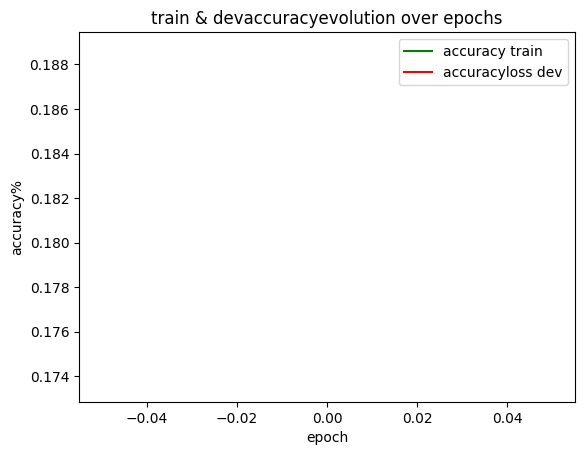

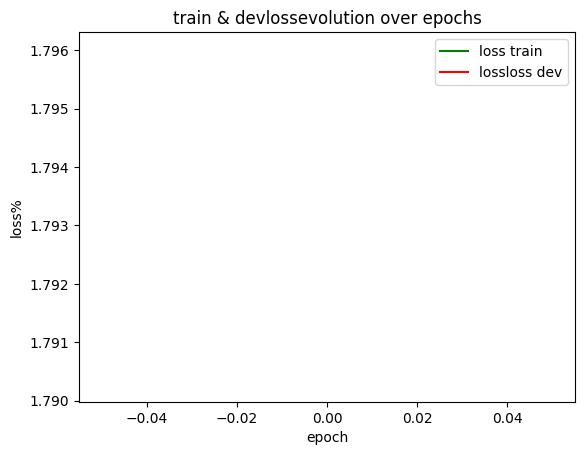

Epoch [2/170], train_Loss: 1.7710, train_Accuracy: 18.81%
Epoch [2/170], dev_Loss: 1.6683, dev_Accuracy: 17.36%
Epoch [3/170], train_Loss: 1.7946, train_Accuracy: 18.81%
Epoch [3/170], dev_Loss: 1.7568, dev_Accuracy: 17.36%
Epoch [4/170], train_Loss: 1.7970, train_Accuracy: 18.81%
Epoch [4/170], dev_Loss: 1.8149, dev_Accuracy: 17.36%
Epoch [5/170], train_Loss: 1.7784, train_Accuracy: 18.81%
Epoch [5/170], dev_Loss: 1.8277, dev_Accuracy: 17.36%
Epoch [6/170], train_Loss: 1.7928, train_Accuracy: 19.47%
Epoch [6/170], dev_Loss: 1.7820, dev_Accuracy: 19.62%
Epoch [7/170], train_Loss: 1.7620, train_Accuracy: 18.79%
Epoch [7/170], dev_Loss: 1.9232, dev_Accuracy: 17.36%
Epoch [8/170], train_Loss: 1.7808, train_Accuracy: 19.22%
Epoch [8/170], dev_Loss: 1.6176, dev_Accuracy: 19.62%
Epoch [9/170], train_Loss: 1.7785, train_Accuracy: 18.75%
Epoch [9/170], dev_Loss: 1.6236, dev_Accuracy: 19.97%
Epoch [10/170], train_Loss: 1.7537, train_Accuracy: 18.73%
Epoch [10/170], dev_Loss: 1.6545, dev_Accurac

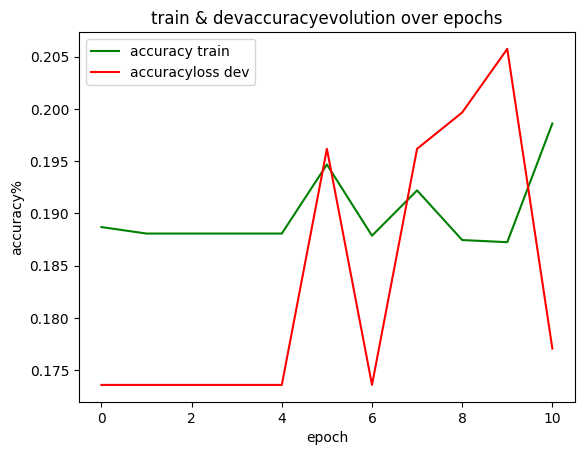

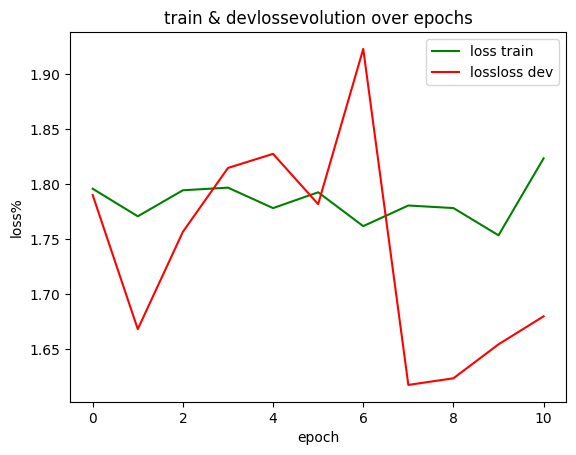

Epoch [12/170], train_Loss: 1.7336, train_Accuracy: 19.47%
Epoch [12/170], dev_Loss: 1.6725, dev_Accuracy: 21.35%
Epoch [13/170], train_Loss: 1.7864, train_Accuracy: 20.68%
Epoch [13/170], dev_Loss: 1.6927, dev_Accuracy: 20.83%
Epoch [14/170], train_Loss: 1.7718, train_Accuracy: 18.83%
Epoch [14/170], dev_Loss: 1.8500, dev_Accuracy: 18.40%
Epoch [15/170], train_Loss: 1.7870, train_Accuracy: 19.51%
Epoch [15/170], dev_Loss: 1.9854, dev_Accuracy: 19.18%
Epoch [16/170], train_Loss: 1.7901, train_Accuracy: 20.40%
Epoch [16/170], dev_Loss: 1.7027, dev_Accuracy: 21.79%
Epoch [17/170], train_Loss: 1.7634, train_Accuracy: 19.57%
Epoch [17/170], dev_Loss: 1.6993, dev_Accuracy: 21.79%
Epoch [18/170], train_Loss: 1.8329, train_Accuracy: 20.58%
Epoch [18/170], dev_Loss: 1.5807, dev_Accuracy: 20.49%
Epoch [19/170], train_Loss: 1.7662, train_Accuracy: 19.63%
Epoch [19/170], dev_Loss: 2.0738, dev_Accuracy: 18.84%
Epoch [20/170], train_Loss: 1.7775, train_Accuracy: 18.40%
Epoch [20/170], dev_Loss: 1.6

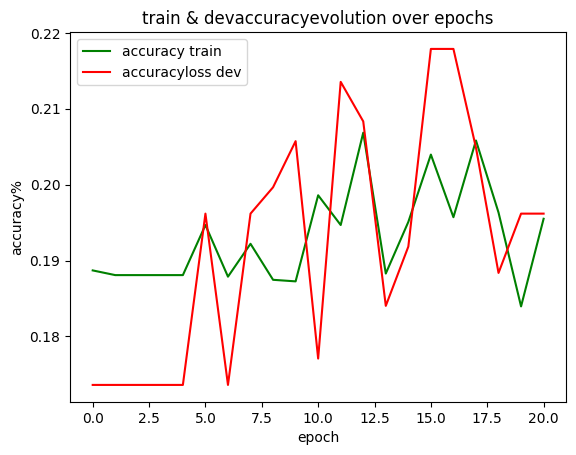

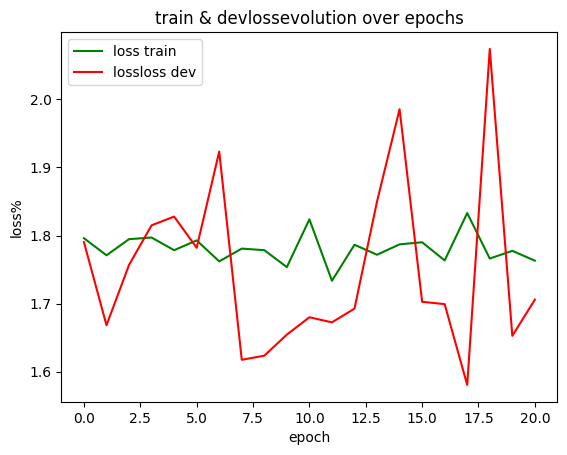

Epoch [22/170], train_Loss: 1.7945, train_Accuracy: 19.08%
Epoch [22/170], dev_Loss: 1.8752, dev_Accuracy: 19.70%
Epoch [23/170], train_Loss: 1.7618, train_Accuracy: 19.39%
Epoch [23/170], dev_Loss: 1.9494, dev_Accuracy: 19.79%
Epoch [24/170], train_Loss: 1.7593, train_Accuracy: 20.35%
Epoch [24/170], dev_Loss: 1.8935, dev_Accuracy: 20.57%
Epoch [25/170], train_Loss: 1.7894, train_Accuracy: 19.18%
Epoch [25/170], dev_Loss: 1.6985, dev_Accuracy: 21.01%
Epoch [26/170], train_Loss: 1.7611, train_Accuracy: 19.88%
Epoch [26/170], dev_Loss: 1.8932, dev_Accuracy: 19.62%
Epoch [27/170], train_Loss: 1.7772, train_Accuracy: 18.95%
Epoch [27/170], dev_Loss: 2.1221, dev_Accuracy: 18.75%
Epoch [28/170], train_Loss: 1.7768, train_Accuracy: 19.94%
Epoch [28/170], dev_Loss: 1.9741, dev_Accuracy: 20.92%
Epoch [29/170], train_Loss: 1.7767, train_Accuracy: 19.08%
Epoch [29/170], dev_Loss: 1.6709, dev_Accuracy: 18.06%
Epoch [30/170], train_Loss: 1.8023, train_Accuracy: 19.36%
Epoch [30/170], dev_Loss: 1.7

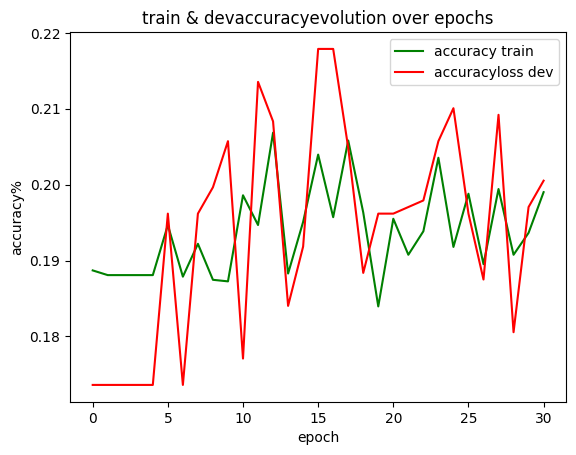

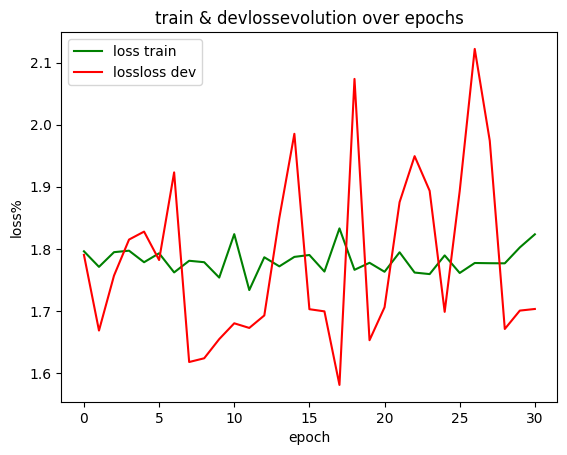

Epoch [32/170], train_Loss: 1.7647, train_Accuracy: 19.86%
Epoch [32/170], dev_Loss: 1.8484, dev_Accuracy: 17.97%
Epoch [33/170], train_Loss: 1.7828, train_Accuracy: 19.01%
Epoch [33/170], dev_Loss: 1.8594, dev_Accuracy: 19.62%
Epoch [34/170], train_Loss: 1.7627, train_Accuracy: 20.02%
Epoch [34/170], dev_Loss: 1.7398, dev_Accuracy: 20.49%
Epoch [35/170], train_Loss: 1.7905, train_Accuracy: 19.69%
Epoch [35/170], dev_Loss: 1.7230, dev_Accuracy: 20.92%
Epoch [36/170], train_Loss: 1.7624, train_Accuracy: 19.49%
Epoch [36/170], dev_Loss: 1.8707, dev_Accuracy: 20.49%
Epoch [37/170], train_Loss: 1.7915, train_Accuracy: 19.80%
Epoch [37/170], dev_Loss: 1.6852, dev_Accuracy: 19.62%
Epoch [38/170], train_Loss: 1.7587, train_Accuracy: 19.08%
Epoch [38/170], dev_Loss: 1.7056, dev_Accuracy: 18.49%
Epoch [39/170], train_Loss: 1.7618, train_Accuracy: 20.09%
Epoch [39/170], dev_Loss: 1.6213, dev_Accuracy: 20.40%
Epoch [40/170], train_Loss: 1.7891, train_Accuracy: 20.13%
Epoch [40/170], dev_Loss: 1.6

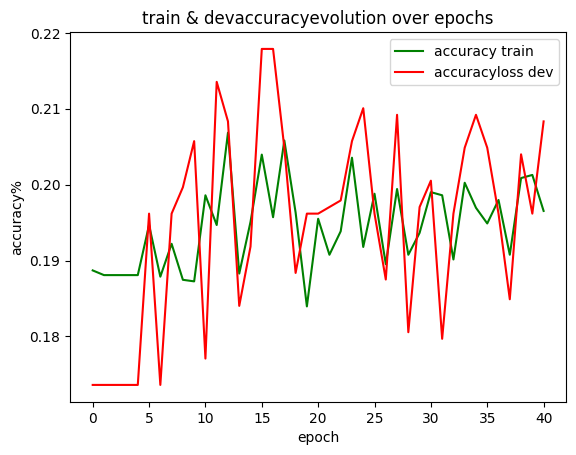

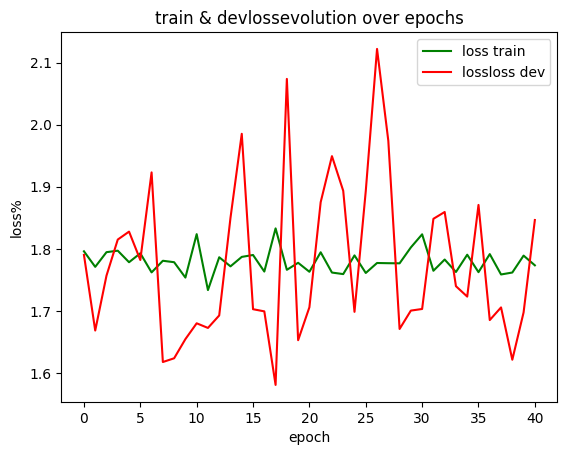

Epoch [42/170], train_Loss: 1.7543, train_Accuracy: 19.92%
Epoch [42/170], dev_Loss: 1.8555, dev_Accuracy: 21.18%


KeyboardInterrupt: ignored

In [ ]:
# Instantiate the model, optimizer and loss function


np.random.seed(random_seed)

#gpu
cuda = is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=MMTM, weight_decay=WD)
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WD)



acc_train_list, loss_train_list, acc_val_list, loss_val_list = model_train(EPOCHS, net, trainloader , validloader, optimizer, criterion, device )
plot_loss_acc(acc_train_list, acc_val_list, "accuracy")
plot_loss_acc(loss_train_list, loss_val_list, "loss")

In [ ]:
# !python main.py ./Chessman-image-dataset/prepro_chess 0.05 7 40